# Creating gymnasium environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import random as rd
import time

from gym import Env, spaces

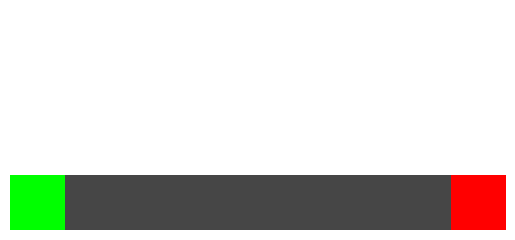

start at coordinates: (3, 0)


In [2]:
class Coor():
    def __init__(self, coor):
        self.x = coor[0]
        self.y = coor[1]

    def get(self):
        return self.x, self.y
    
    def __str__(self):
        return "(" + str(self.x) + ", " + str(self.y) + ")"
    
    def __add__(self, coor2):
        return Coor((self.x + coor2.x, self.y + coor2.y))
    
    def __eq__(self, coor2):
        if coor2 == None:
            return False
        return (self.x==coor2.x) and (self.y==coor2.y)
    
    def dist(self, coor2):
        a,b = self.get()
        c,d = self.get()
        return np.sqrt(a*c + b*d)

RED = [255, 0, 0]
GREEN = [0, 255, 0]
BLUE = [0, 0, 255]
GREY = [70 for _ in range(3)]
WHITE = [255 for _ in range(3)]

START_CHAR = 2
END_CHAR = 3
CAR_CHAR = 4

def color(b):
    if b == START_CHAR:
        return GREEN
    elif b == END_CHAR:
        return RED
    elif b == 1:
        return GREY
    else:
        return WHITE


class Track():
    def __init__(self, tab):
        self.height = len(tab)
        self.width = len((tab[0]))
        self.info_track = tab
        self.color_track = [[color(x) for x in y] for y in tab]

        self.end = None
        self.start = None
        for i in range(self.height):
            for j in range(self.width):
                if tab[i][j] == START_CHAR:
                    self.start = Coor((i,j))
                if tab[i][j] == END_CHAR:
                    self.end = Coor((i,j))

    def get_color(self, coor:Coor):
        """return the color of the case x,y"""
        x,y = coor.get()
        return color(self.info_track[x][y])
    
    def is_wall(self, coor:Coor):
        """Return True if case (x,y) is a wall"""
        x,y = coor.get()
        return (self.info_track[x][y] == 1)

    def get_start(self):
        """Return coordinate of start"""
        return self.start.get()
    
    def get_end(self):
        """Return coordinate of end"""
        return self.end.get()

    def plot(self):
        """Plot the track using matplotlib"""
        plt.imshow(self.color_track)
        plt.axis("off")
        plt.show()


track_1_info = [[1, 1, 1, 1, END_CHAR],
                [1, 1, 1, 0, 0],
                [1, 1, 0, 0, 0],
                [1, 0, 0, 0, 0],
                [START_CHAR, 0, 0, 0, 1]]

gobelin_info = [[0, 0, 0, 0, 0, 0, 0, 0, 0],
           [0, 0, 0, 0, 0, 0, 0, 0, 0],
           [0, 0, 0, 0, 0, 0, 0, 0, 0],
           [START_CHAR, 1, 1, 1, 1, 1, 1, 1, END_CHAR]]

track_1 = Track(gobelin_info)
track_1.plot()
print("start at coordinates:", track_1.get_start())

In [3]:
CAR_ICON = [[BLUE]]

In [11]:
class MyEnv(Env):
    def __init__(self, track: Track):
        super(MyEnv, self).__init__()

        # Define a 2-D observation space
        self.observation_shape = (track.height, track.width, 3)
        self.observation_space = spaces.Box(low = np.zeros(self.observation_shape), 
                                            high = np.ones(self.observation_shape),
                                            dtype = np.int64)

        # Define an action space ranging from 0 to 3
        self.action_space = [i for i in range(4)]

        self.track = track
        self.car = Coor(self.track.get_start())
        # self.car_icon = cv2.imread("blue_dot.png") /255
        self.car_icon = np.array(CAR_ICON)

        self.canvas = np.array(self.track.color_track)

        # self.action_meanings = {0: "Right", 1: "Left", 2: "Down", 3: "Up"}

    def get_state(self):
        """Return actual state of the env"""
        state = np.array(self.track.info_track)
        x,y = self.car.get()
        state[x][y] = CAR_CHAR
        return state

    def draw_car(self):
        """Add the car_icon to the canvas"""
        car_shape = self.car_icon.shape
        x,y = self.car.get()
        self.canvas[x:x + car_shape[1], y:y + car_shape[0]] = self.car_icon

    def reset(self):
        """Reset the environment"""
        self.car = Coor(self.track.get_start())
        self.canvas = np.array(self.track.color_track)
        self.draw_car()
        return self.canvas

    def render(self, mode = "human", waiting_time=0.1):
        """Render the environment"""
        assert mode in ["human", "rgb_array"], "Invalid mode, must be either \"human\" or \"rgb_array\""
        self.canvas = np.array(self.track.color_track)
        self.draw_car()
        if mode == "human":
            plt.imshow(self.canvas)
            plt.axis("off")
            display.clear_output(wait=True)
            plt.show()
            time.sleep(waiting_time)
    
        elif mode == "rgb_array":
            return self.canvas
        

    def move(self, action):
        """Return the move cooresponding to action"""
        if action == 0:
            return Coor((0, 1))
        elif action == 1:
            return Coor((0, -1))
        elif action == 2:
            return Coor((1, 0)) #because top is at row 0
        else:
            return Coor((-1,0))

    def is_case_ridable(self, coor: Coor):
        """Return if the car can go on the case or not"""
        x,y = coor.get()
        if not (x>=0 and x<self.track.height and y>=0 and y<self.track.width):
            return False
        return True
        return not self.track.is_wall(coor)
    
    def possible_action(self, coor=None):
        """Return a list of possible action according to the coordinates"""
        if coor==None:
            coor = self.car
        actions = []
        if self.is_case_ridable(coor+ Coor((0,-1))):
            actions.append(1)
        if self.is_case_ridable(coor + Coor((0, 1))):
            actions.append(0)
        if self.is_case_ridable(coor + Coor((1, 0))):
            actions.append(2)
        if self.is_case_ridable(coor + Coor((-1,0))):
            actions.append(3)
        return actions
        
    def step(self, action):
        """Do a step, we suppose that the action is a possible one"""
        is_done = False
        reward = -0.5

        mv = self.move(action)
        next_move = self.car + mv
        reward += next_move.dist(self.track.end) - self.car.dist(self.track.end)
        self.car = next_move

        if self.car == self.track.end:
            reward = 100
            is_done = True

        if self.track.is_wall(self.car):
            reward = -100
            is_done = True

        return self.canvas, reward, is_done, []
    
    def random_action(self):
        """Return random possible action"""
        return rd.choice(self.possible_action())
        
        

env = MyEnv(track_1)

# Genetic algo

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

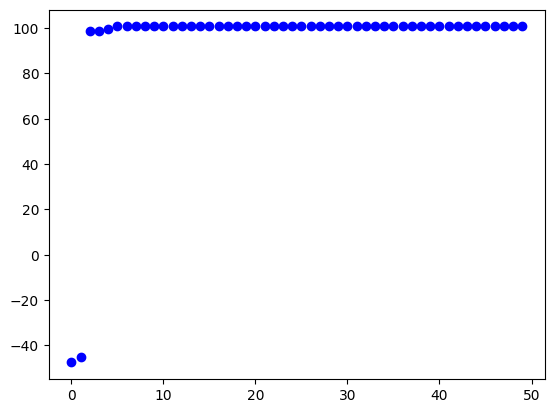

In [28]:
LEN_POP = 1000

def gen_indiv():
    indiv = np.empty([track_1.height, track_1.width], int)
    for i in range(track_1.height):
        for j in range(track_1.width):
            indiv[i][j] = rd.choice(env.possible_action(Coor((i,j))))
    return indiv

def gen_pop():
    return [gen_indiv() for i in range(LEN_POP)]

def mutate_indiv(indiv):
    nb_mutations = min(track_1.height, track_1.width)
    for _ in range(nb_mutations):
        x = rd.randint(0, track_1.height -1)
        y = rd.randint(0, track_1.width - 1)
        indiv[x][y] = rd.choice(env.possible_action(Coor((x,y))))

def cross_over(indiv1, indiv2):
    child = np.empty([track_1.height, track_1.width], int)
    for i in range(track_1.height):
        for j in range(track_1.width):
            child[i][j] = rd.choice([indiv1[i][j], indiv2[i][j]])
    return child

def score(indiv, show=False):
    score = 0
    env.reset()
    running = True
    step = 0
    while running:
        step += 1
        # Take a random action
        x,y = env.car.get()
        action = indiv[x][y]
        obs, reward, done, info = env.step(action)
        score += reward

        # Render the game
        if show:
            env.render(waiting_time=0.01)

        if done == True or step > 100:
            running = False
    return score


def sort_pop(pop):
    pop.sort( key = lambda x: -score(x))

def copy_indiv(indiv):
    return np.array([[indiv[i][j] for j in range(track_1.width)] for i in range(track_1.height)])

def select_pop(pop):
    new_pop = []
    pourcentage = 0.3
    k = int( (1 + np.sqrt(1 + 8*pourcentage*LEN_POP)) / 2 ) 

    for i in range( int(0.3*LEN_POP) ):
        new_pop.append(pop[i])
        
    for i in range(k):
        for j in range(i+1, k):
            new_pop.append(cross_over(pop[i], pop[j]))
    
    for i in range(int(LEN_POP*0.2)):
        new_indiv = copy_indiv(pop[i])
        mutate_indiv(new_indiv)
        new_pop.append(new_indiv)

    while (len(new_pop) != LEN_POP):
        new_pop.append(gen_indiv())

    return new_pop


def algo_gen():
    NB_GEN = 50
    pop = gen_pop()
    for gen in range(NB_GEN):
        sort_pop(pop)
        pop = select_pop(pop)
        if gen % 1 == 0:
            print(gen, end=" ")
            #score(pop[0], True)
        plt.plot(gen, score(pop[0]), 'o', color='blue')
    plt.show()
    return pop[0]
        

best = algo_gen()


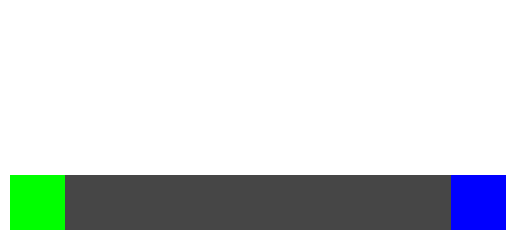

In [29]:
score(best, True)
env.close()